In [1]:
import os
import time as T
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from bindsnet.network.monitors import Monitor
from bindsnet.encoding import poisson
from bindsnet.models import DiehlAndCook2015, CANs
from bindsnet.preprocessing import NumentaPreprocessor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

In [2]:
datapath = './dataset/'
encpath = './encoding/'
datafiles = [os.path.join(datapath, x) for x in os.listdir(datapath)]
encfiles = [os.path.join(encpath, x[:-4])+'.enc' for x in os.listdir(datapath)]

In [3]:
enc = NumentaPreprocessor()

In [4]:
encodings = [enc.process(csvfile=d, use_cache=True, cachedfile=e)
             for d, e in zip(datafiles, encfiles)]

In [5]:
tracklist = sorted(zip(encfiles, encodings))

In [6]:
time = 500

In [7]:
network = CANs(5000)
for layer in network.layers:
    if 'CAN-' in layer:
        mon = Monitor(network.layers[layer], ['v', 's'], time=time)
        network.add_monitor(mon, name=layer)

In [8]:
def relax(network, time=50):
    img = torch.zeros(5000)
    inpts = {'X': poisson(img, time)}
    network.run(inpts=inpts, time=time)

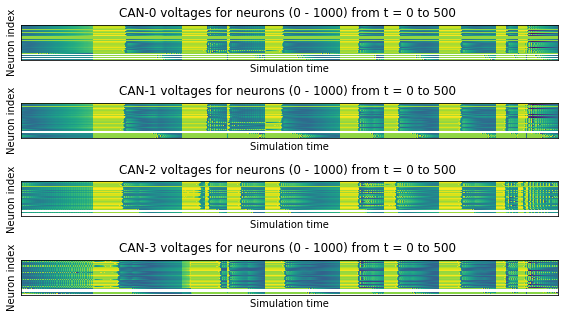

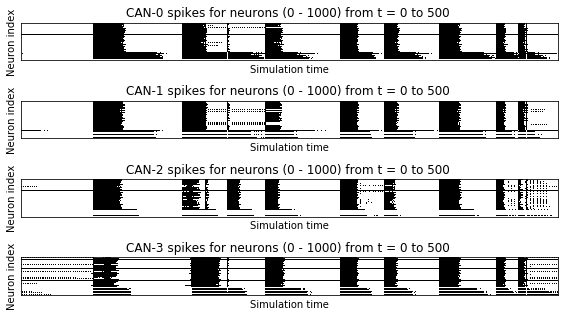

Track track01   Iteration 14


In [ ]:
start = int(T.time())
for name, track in tracklist:
    for i in range(4, len(track)):
        print(f'Track {os.path.basename(name)[:-4]}   Iteration {i-3}')
        
        orig = torch.cat((track[i-4], track[i-3], track[i-2], track[i-1], track[i]))* 255
        pt = orig
        for i in range(1, time):
            pt = torch.cat((pt, orig))
        
        inpts = {'X': pt}
        network.run(inpts=inpts, time=time)
        relax(network)
        
        spikes = {}
        voltages = {}
        for mon in network.monitors:
            spikes[mon] = network.monitors[mon].get('s')
            voltages[mon] = network.monitors[mon].get('v')
            
        
        plot_voltages(voltages)
        plot_spikes(spikes)
        
        clear_output(wait=True)
        plt.pause(1)
        
network.save(f'trained_{start}.net')